In [1]:
import pandas as pd
import numpy as np


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data_ts_1 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds main data.csv")


In [3]:
data_ts_2 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds main data 2.csv")

In [5]:
data_ts_1.rename(columns={data_ts_1.columns[0]:"Bloomberg Ticker"}, inplace=True)
data_ts_1.rename(columns={data_ts_1.columns[1]:"Variable"}, inplace= True)

In [6]:
data_ts_2.rename(columns={data_ts_2.columns[1]:"Variable"}, inplace = True)
data_ts_2.rename(columns={data_ts_2.columns[0]:"Bloomberg Ticker"}, inplace=True)

In [7]:
data_ts_1 = data_ts_1.iloc[:,:-1]

In [8]:
data_ts_1['Bloomberg Ticker'] = data_ts_1['Bloomberg Ticker'].ffill()
data_ts_2['Bloomberg Ticker'] = data_ts_2['Bloomberg Ticker'].ffill()

In [9]:
data_ts_1_long = pd.melt(data_ts_1, id_vars=["Bloomberg Ticker","Variable"], value_vars=data_ts_1.columns[2:], var_name="Date", value_name='Value')

In [10]:
data_ts_2_long = pd.melt(data_ts_2, id_vars=["Bloomberg Ticker", "Variable"], value_vars=data_ts_2.columns[2:], var_name="Date", value_name="Value")

In [11]:
merged_data = pd.merge(data_ts_1_long, data_ts_2_long, on=['Bloomberg Ticker', 'Variable', 'Date'], how='left', suffixes=('_main','_subset'))

In [13]:
merged_data['Value_main'].replace('#N/A Review',np.nan, inplace=True)
merged_data['Value_main'].replace('#NAME?',np.nan, inplace=True)
merged_data['Value_subset'].replace(' ',np.nan, inplace=True)

merged_data['Value_main'] = merged_data['Value_main'].astype(float)
merged_data['Value_subset'] = merged_data['Value_subset'].astype(float)


#print(merged_data.dtypes)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/2448527503.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Value_main'].replace('#N/A Review',np.nan, inplace=True)
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/2448527503.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [14]:
merged_data['Combined'] = merged_data['Value_main'].combine_first(merged_data['Value_subset'])

In [15]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format = '%m/%d/%y', errors='coerce')

In [16]:
merged_data['Date_M_Y'] = merged_data['Date'].dt.to_period('M')

In [17]:
merged_data.sort_values(by=['Bloomberg Ticker','Variable', 'Date'], inplace=True)

In [18]:
merged_data.drop_duplicates(subset=['Bloomberg Ticker', 'Variable', 'Combined'], inplace=True)

In [19]:
indices_to_drop = merged_data[merged_data['Bloomberg Ticker'] == '2284'].index
print(indices_to_drop)

merged_data.drop(index=indices_to_drop, inplace = True)

Index([11996, 11994, 11993, 11995, 11992, 11991], dtype='int64')


In [20]:
pivot = merged_data.pivot_table(index=['Bloomberg Ticker', 'Date'], columns='Variable', values="Combined", aggfunc='first').reset_index()

In [21]:
pivot['Date'] = pivot['Date'].dt.to_period('M')

In [22]:
#Adding a column which will classify the security
pivot['Classification'] = 'Corporate Green Bond'

In [23]:
pivot.index = pivot['Date']

Import second time series dataset. Macroeconomic and stock market variables.

In [24]:
data_ts_3 = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/Time series second phase cleaned & merged.csv")

In [25]:
data_ts_3.head()

,Description,10/29/21,11/30/21,12/31/21,1/31/22,2/28/22,3/31/22,4/29/22,5/31/22,6/30/22,...,1/31/24,2/29/24,3/29/24,4/30/24,5/31/24,6/28/24,7/31/24,8/30/24,9/30/24,10/31/24
0,S&P500 VOLATILITY INDEX,16.26,27.19,17.22,24.83,30.15,20.56,33.40,26.19,28.71,...,14.35,13.40,13.01,15.65,12.92,12.44,16.36,15.00,16.73,23.16
1,S&P500 PX_LAST,4605.38,4567.00,4766.18,4515.55,4373.94,4530.41,4131.93,4132.15,3785.38,...,4845.65,5096.27,5254.35,5035.69,5277.51,5460.48,5522.30,5648.40,5762.48,5705.45
2,S&P500 PX_BID,4561.03,4528.64,4701.56,4459.92,4299.02,4499.97,4108.68,4094.66,3733.31,...,4814.01,5042.80,5200.84,4970.00,5224.07,5426.23,5484.77,5571.95,5700.44,5669.85
3,S&P500 PX_ASK,4677.16,4647.79,4834.94,4568.93,4419.26,4587.05,5434.72,4178.75,3819.46,...,4895.08,5160.48,5309.45,5075.58,5328.88,5513.21,5595.24,5713.68,5803.09,5764.36
4,EURO STOXX 50,4250.56,4063.06,4298.41,4174.60,3924.23,3902.52,3802.86,3789.21,3454.86,...,4648.40,4877.77,5083.42,4921.22,4983.67,4894.02,4872.94,4957.98,5000.45,4827.63


In [26]:
data_ts_3_pivot = data_ts_3.T

In [27]:
data_ts_3_pivot.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
Description,S&P500 VOLATILITY INDEX,S&P500 PX_LAST,S&P500 PX_BID,S&P500 PX_ASK,EURO STOXX 50,STOXX EUROPE 600,EURO STOXX 50 VOLATILITY,EUROPEAN RENEWABLE ENERGY INDEX,US IMPLIED YIELD VOLATILITY INDEX,GOLD IN EUR PX_LAST,...,EUROZONE 7-YEAR BOND YTM_ASK,EUROZONE 5-YEAR BOND YTM_BID,EUROZONE 5-YEAR BOND YTM_ASK,EUROZONE 3-YEAR BOND YTM_BID,EUROZONE 3-YEAR BOND YTM_ASK,EUROZONE 2-YEAR BOND YTM_BID,EUROZONE 2-YEAR BOND YTM_ASK,NASDAQ CLEAN EDGE GREEN ENERGY,MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET I...,BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE
10/29/21,16.26,4605.38,4561.03,4677.16,4250.56,475.51,17.6164,2458.32,75.45,1542.54,...,-0.264,-0.39,-0.394,-0.542,-0.553,-0.585,-0.597,1012.5,1864.62,105.61
11/30/21,27.19,4567.0,4528.64,4647.79,4063.06,462.96,30.0679,2294.14,84.04,1565.07,...,-0.519,-0.618,-0.627,-0.744,-0.759,-0.737,-0.756,1008.21,1808.27,100.34
12/31/21,17.22,4766.18,4701.56,4834.94,4298.41,487.8,19.2677,2216.63,77.1,1608.82,...,-0.366,-0.453,-0.469,-0.641,-0.67,-0.62,-0.651,889.43,1880.8,106.93
1/31/22,24.83,4515.55,4459.92,4568.93,4174.6,468.88,27.0084,1970.35,85.14,1599.48,...,-0.179,-0.22,-0.234,-0.426,-0.436,-0.528,-0.544,748.43,1734.29,100.96


In [28]:
data_ts_3_pivot.columns = data_ts_3_pivot.iloc[0]

In [29]:
data_ts_3_pivot = data_ts_3_pivot.drop(index='Description')

In [30]:
data_ts_3_pivot.index = pd.to_datetime(data_ts_3_pivot.index, format='%m/%d/%y')
data_ts_3_pivot.index = data_ts_3_pivot.index.to_period('M')

In [31]:
data_ts_3_pivot.index.name = 'Date'

Merging the two datasets


In [32]:
pivot = pivot.drop(columns='Date')

In [33]:
final_1 = pd.merge(pivot, data_ts_3_pivot, how='outer', on='Date')

In [34]:
final_1.rename(columns={final_1.columns[0]:'Ticker'}, inplace=True)

Static data import and merge

In [35]:
static_1 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 2.csv')

In [36]:
static_1.rename(columns={static_1.columns[0]:'Ticker'}, inplace=True)

In [37]:
static_2 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 3.csv')

In [38]:
static_2.rename(columns={static_2.columns[7]:'Ticker'}, inplace=True)

In [39]:
static_3 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 4.csv')

In [40]:
static_3.rename(columns={static_3.columns[11]:'Ticker'}, inplace=True)

In [41]:
static_4 = pd.read_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/Bonds Static data 5_use of proceeds.csv')

In [42]:
static_4.rename(columns={static_4.columns[1]:'Ticker'}, inplace= True)

In [43]:
final_1['Date'] = final_1.index

In [44]:
final_2 = pd.merge(final_1, static_1,  how='outer', on='Ticker')

In [45]:
final_2 = pd.merge(final_2, static_2,  how='outer', on='Ticker')

In [46]:
final_2 = pd.merge(final_2, static_3,  how='outer', on='Ticker')

In [47]:
final_2 = pd.merge(final_2, static_4,  how='outer', on='Ticker')

In [48]:
final_2.replace('#N/A Field Not Applicable', np.nan, inplace=True)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/1454516632.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_2.replace('#N/A Field Not Applicable', np.nan, inplace=True)


In [49]:
final_2.index = final_2['Date']

In [50]:
final_2 = final_2.drop(columns='Date')

Analysing of dataset

In [51]:
pd.set_option('display.max_rows', None)
#print(final_2.dtypes)

In [52]:
#print(type(final_2))

In [53]:
pd.set_option('display.max_rows', None)
#print(final_2.dtypes)

In [54]:

def convert_columns(final_2, max_unique_ratio=0.1, max_unique_count=20):
    for col in final_2.columns:
        print(f"Processing column: {col}")

        # Step 1: Handle numeric conversion more robustly
        try:
            # First try converting to numeric, preserving original type if possible
            numeric_series = pd.to_numeric(final_2[col], errors='coerce')
            
            # Check if conversion was meaningful
            if not numeric_series.isna().all():
                # Prefer integer if no decimal loss
                if np.allclose(numeric_series, numeric_series.astype(int), rtol=1e-5, atol=1e-8):
                    final_2[col] = numeric_series.astype(int)
                    print(f"Column {col} converted to integer")
                else:
                    final_2[col] = numeric_series.astype(float)
                    print(f"Column {col} converted to float")
                continue
        except Exception as e:
            print(f"Detailed error converting column {col} to numeric: {e}")

        # Step 2: Handle categorical columns more carefully
        if final_2[col].dtype == 'object':
            unique_count = final_2[col].nunique()
            total_count = len(final_2[col])
            
            # Multiple checks for categorical
            if (unique_count / total_count < max_unique_ratio) or \
               (0 < unique_count <= max_unique_count):
                final_2[col] = final_2[col].astype('category')
                print(f"Column {col} converted to category")

    return final_2

In [ ]:
final_2 = convert_columns(final_2)

Processing column: Ticker
Column Ticker converted to category
Processing column: PX_ASK
Detailed error converting column PX_ASK to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: PX_BID
Detailed error converting column PX_BID to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: YLD_YTM_ASK
Detailed error converting column YLD_YTM_ASK to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: YLD_YTM_BID
Detailed error converting column YLD_YTM_BID to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: Classification
Column Classification converted to category
Processing column: S&P500 VOLATILITY INDEX
Detailed error converting column S&P500 VOLATILITY INDEX to numeric: Cannot convert non-finite values (NA or inf) to integer
Processing column: S&P500 PX_LAST
Detailed error converting column S&P500 PX_LAST to numeric: Cannot convert non-finite values (NA or in

In [56]:
final_2['Issue Price'] = final_2['Issue Price'].astype(float)
final_2['Issue Date'] = pd.to_datetime(final_2['Issue Date'],format='%m/%d/%Y', errors='coerce')

In [57]:
final_2 = final_2.copy()

final_2['Issue Price'] = final_2['Issue Price'].astype(float)
final_2['Issue Date'] = pd.to_datetime(final_2['Issue Date'], format='%m/%d/%Y', errors='coerce')

In [58]:
#print(final_2.dtypes)

In [59]:
final_2.reset_index(inplace=True)
final_3 = final_2.dropna(subset=['Date','YLD_YTM_ASK'], how='all', inplace=False)


In [60]:
#drop entries where all four variables are missing
final_3 = final_3.dropna(subset=['YLD_YTM_ASK','YLD_YTM_BID','PX_ASK','PX_BID'], how='all')

In [61]:
# Count rows where exactly 4 specified columns have NaN values
count = final_3[['YLD_YTM_ASK', 'YLD_YTM_BID', 'PX_ASK', 'PX_BID']].isna().sum(axis=1).eq(4).sum()
print(count)

0


In [64]:
#Extraction of date components
final_3['year'] = final_3['Date'].dt.year
final_3['month'] = final_3['Date'].dt.month
final_3['quarter'] = final_3['Date'].dt.quarter


In [65]:
# Accounting for cyclicality of months (allowing proximity of month 12 to month 1 to be observed)
final_3['month_sin'] = np.sin(2 * np.pi * final_3['month'] / 12)
final_3['month_cos'] = np.cos(2 * np.pi * final_3['month'] / 12)

Encoding of string variables


In [66]:
final_2.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/final_2.csv', index=True)

In [67]:
cpn_freq = pd.read_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/ISIN_CPN_FREQ_BBG.csv")

In [68]:
#print(cpn_freq.dtypes)
#print(final_2.dtypes)

#cpn_freq['Ticker'] = cpn_freq["Ticker"].astype('category')

In [69]:
#print(final_2['Ticker'].cat.categories)
#print(cpn_freq['Ticker'].cat.categories)

In [70]:
final_merge = pd.merge(final_2, cpn_freq, on=["Ticker"])

In [71]:
# An easier way to drop the missing value rows
final_merge = final_merge.dropna(subset=['Ticker', 'Date'])

In [72]:
# Bit more complex way to drop the missing value rows
to_drop = final_merge[(final_merge['Ticker']==' ') | (final_merge['Date']==' ')]
final_merge =final_merge.drop(to_drop.index)

In [74]:
#Convert dates into constant format
final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'])
#final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'], format = '%m/%d/%Y').dt.strftime('%d/%m/%Y')
#final_merge['Maturity'] = pd.to_datetime(final_merge['Maturity'], format='%d/%m/%Y')
final_merge['Date'] = final_merge['Date'].dt.to_timestamp('M')

In [75]:
# Calculating mid price 
final_merge['Mid_PX'] = (((final_merge['PX_ASK']+final_merge['PX_BID'])/2))


In [76]:
#back calculating the coupon dates
coupon_1 = ['ISIN','Ticker','Maturity','Issue Date','Cpn','Date','CPN_FREQ','Par Amount']
coupon_dates = final_merge[coupon_1]

In [77]:
coupon_dates['Accrual period'] = (360/(coupon_dates['CPN_FREQ']))
coupon_dates['period_coupon'] =  ((coupon_dates['Cpn'])/coupon_dates['CPN_FREQ'])
coupon_dates['period_months'] = 12/ coupon_dates['CPN_FREQ']
#((coupon_dates['Cpn'])/(coupon_dates['CPN_FREQ']))*100

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/849711941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coupon_dates['Accrual period'] = (360/(coupon_dates['CPN_FREQ']))
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/849711941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coupon_dates['period_coupon'] =  ((coupon_dates['Cpn'])/coupon_dates['CPN_FREQ'])
/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/849711941.py:3: SettingWithCopyWarning: 
A value

In [78]:
df = coupon_dates.copy()

from pandas.api.types import is_period_dtype, is_datetime64_any_dtype

# 1) Core dtypes
df['Maturity']   = pd.to_datetime(df['Maturity'], errors='coerce')
df['Issue Date'] = pd.to_datetime(df['Issue Date'], errors='coerce')
df['CPN_FREQ']   = pd.to_numeric(df['CPN_FREQ'], errors='coerce').astype('Int64')
df['Cpn']        = pd.to_numeric(df['Cpn'], errors='coerce')

# 2) Normalize Date to month-end Timestamp without ever passing Period to to_datetime
if is_period_dtype(df['Date']):
    # Already Period[M] -> convert to month-end timestamps
    df['Date'] = df['Date'].dt.to_timestamp('M')
elif is_datetime64_any_dtype(df['Date']):
    # Already datetime -> push to month-end
    df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)
else:
    # Likely strings like '2021-10' -> parse, then month-end
    # (If your strings are strictly YYYY-MM, the format speeds parsing)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m', exact=False)
    df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/2168478596.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if is_period_dtype(df['Date']):


In [79]:
# building last/next coupon dates per row
def last_next_coupon_from_maturity(maturity, freq, valuation_date):
    """
    Build schedule backward from maturity stepping 12/f months.
    Return (last_coupon_date, next_coupon_date) around valuation_date.
    """
    if pd.isna(freq) or freq not in (1, 2, 4):
        return (pd.NaT, pd.NaT)

    period_months = int(12 // int(freq))
    schedule = []
    d = maturity
    cutoff = valuation_date - pd.DateOffset(years=30)  # far enough back

    while d > cutoff:
        schedule.append(d)
        d = d - pd.DateOffset(months=period_months)

    schedule.sort()
    if not schedule:
        return (pd.NaT, pd.NaT)

    # last <= valuation_date
    last_cpn = None
    for dt in schedule:
        if dt <= valuation_date:
            last_cpn = dt
        else:
            break

    # next > valuation_date
    next_cpn = next((dt for dt in schedule if dt > valuation_date), pd.NaT)
    if last_cpn is None:
        # valuation before first generated coupon -> treat first as next, no last
        first = schedule[0]
        return (pd.NaT, first)

    return (last_cpn, next_cpn)

In [80]:
#applying the previously generated code
out = df.apply(
    lambda r: pd.Series(
        last_next_coupon_from_maturity(
            r['Maturity'],
            int(r['CPN_FREQ']) if pd.notna(r['CPN_FREQ']) else None,
            r['Date']
        ),
        index=['LastCouponDate', 'NextCouponDate']
    ),
    axis=1
)

df = pd.concat([df, out], axis=1)

In [81]:
#Accrual fraction
days_since_last = (df['Date'] - df['LastCouponDate']).dt.days
days_in_period  = (df['NextCouponDate'] - df['LastCouponDate']).dt.days
df['accrual_frac_act'] = (days_since_last / days_in_period).clip(lower=0, upper=1)

In [82]:
#Approximation of accrual fraction based on 30/360 timeframe
df['accrual_frac_30360'] = (
    (df['Date'] - df['LastCouponDate']).dt.days / (360 / df['CPN_FREQ'])
).clip(lower=0)

In [83]:
# What exactly is happening here??
df['accrual_frac'] = df['accrual_frac_act']

In [84]:
#calculating accrued interest
df['AccruedInterest'] = df['period_coupon'] * df['accrual_frac']
final_merge['period_coupon'] = df['period_coupon']
final_merge['AccruedInterest'] = df['AccruedInterest']

In [85]:
#merging newly calculated data
# keys to join on (adjust to your ID columns)
keys = ['ISIN', 'Ticker', 'Date']  # e.g., ['ISIN', 'Date']

# pick only columns in df that are not already in final_merge (exclude keys)
new_cols = [c for c in df.columns if c not in final_merge.columns and c not in keys]

# if there are no new columns, nothing to do
if new_cols:
    df_sub = df[keys + new_cols].drop_duplicates(subset=keys)
    final_merge = final_merge.merge(df_sub, on=keys, how='left')


In [86]:
#### Debugging last coupon
df['Maturity'] = pd.to_datetime(df['Maturity'], errors='coerce')
# if your Date is 'YYYY-MM', convert to month-end Timestamps
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y-%m')
df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

df['CPN_FREQ'] = pd.to_numeric(df['CPN_FREQ'], errors='coerce').astype('Int64')
df['Cpn']      = pd.to_numeric(df['Cpn'], errors='coerce')

In [87]:
def build_schedule_from_maturity(maturity: pd.Timestamp, freq: int, back_years: int = 40) -> pd.DatetimeIndex:
    if pd.isna(maturity) or pd.isna(freq) or freq not in (1, 2, 4):
        return pd.DatetimeIndex([])
    months = int(12 // int(freq))
    dates = []
    d = maturity
    cutoff = maturity - pd.DateOffset(years=back_years)
    while d >= cutoff:
        dates.append(d)
        d = d - pd.DateOffset(months=months)
    return pd.DatetimeIndex(sorted(dates))

In [88]:
schedules = {}
for isin, g in df.groupby('ISIN', sort=False):
    m = g['Maturity'].iloc[0]
    f = g['CPN_FREQ'].iloc[0]
    schedules[isin] = build_schedule_from_maturity(m, int(f) if pd.notna(f) else None)

In [89]:
def last_next_from_schedule(schedule: pd.DatetimeIndex, valuation: pd.Timestamp):
    if len(schedule) == 0 or pd.isna(valuation):
        return pd.NaT, pd.NaT
    # insertion point *after* valuation
    i = schedule.searchsorted(valuation, side='right')
    last_d = schedule[i-1] if i > 0 else pd.NaT
    next_d = schedule[i]   if i < len(schedule) else pd.NaT
    return last_d, next_d

In [90]:
out = df.apply(
    lambda r: pd.Series(
        last_next_from_schedule(schedules.get(r['ISIN'], pd.DatetimeIndex([])), r['Date']),
        index=['LastCouponDate','NextCouponDate']
    ),
    axis=1
)
df = pd.concat([df, out], axis=1)

In [91]:
# pick one ISIN and inspect
check = df.loc[df['ISIN'].eq(df['ISIN'].iloc[100]), ['Date','LastCouponDate','NextCouponDate']].sort_values('Date').head(12)
print(check)

         Date LastCouponDate LastCouponDate NextCouponDate NextCouponDate
75 2021-10-31     2021-07-17     2021-07-17     2022-01-17     2022-01-17
76 2021-11-30     2021-07-17     2021-07-17     2022-01-17     2022-01-17
77 2021-12-31     2021-07-17     2021-07-17     2022-01-17     2022-01-17
78 2022-01-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
79 2022-02-28     2022-01-17     2022-01-17     2022-07-17     2022-07-17
80 2022-03-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
81 2022-04-30     2022-01-17     2022-01-17     2022-07-17     2022-07-17
82 2022-05-31     2022-01-17     2022-01-17     2022-07-17     2022-07-17
83 2022-06-30     2022-01-17     2022-01-17     2022-07-17     2022-07-17
84 2022-07-31     2022-07-17     2022-07-17     2023-01-17     2023-01-17
85 2022-08-31     2022-07-17     2022-07-17     2023-01-17     2023-01-17
86 2022-09-30     2022-07-17     2022-07-17     2023-01-17     2023-01-17


In [92]:
df = df.iloc[:,:-2]

In [94]:
#calculating dirty_mid
final_merge['dirty_mid'] = (final_merge['Mid_PX']) + (final_merge['AccruedInterest'])

In [95]:
#Debugging last coupon & next coupon attempt 2
# 1) See what columns got suffixed
[c for c in final_merge.columns if c.endswith(('_x','_y'))]

# 2) Check dtypes before/after merge
df[['ISIN','Date','Maturity','CPN_FREQ']].dtypes
final_merge[['ISIN','Date','Maturity','CPN_FREQ']].dtypes

# 3) Did you merge on the right keys?
# If your last/next were computed per (ISIN, Date), you MUST merge on BOTH.

ISIN                object
Date        datetime64[ns]
Maturity    datetime64[ns]
CPN_FREQ             int64
dtype: object

In [96]:
#Evaluation
view1 = ['Date','Issue Date', 'Maturity', 'LastCouponDate','NextCouponDate', 'PX_ASK', 'PX_BID', 'Mid_PX','dirty_mid']
view2 = final_merge[view1]

In [97]:
final_merge.to_csv('/Users/marcohattingh/Desktop/Research Assignment/Data/final_merge.csv', index=False)

In [98]:
#Calculation of returns
final_merge = final_merge.sort_values(['Ticker','Date'])
final_merge['monthly_return_nom'] = final_merge.groupby('Ticker')['dirty_mid'].diff()
final_merge['monthly_return_pct'] = final_merge.groupby('Ticker')['dirty_mid'].pct_change()

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/1940906622.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_merge['monthly_return_pct'] = final_merge.groupby('Ticker')['dirty_mid'].pct_change()


In [99]:
duplicates = final_merge.duplicated(subset=['Ticker','Date']).sum()
print("Duplicate (Ticker,Date) rows:", duplicates)

Duplicate (Ticker,Date) rows: 0


In [100]:
#Activate if interested in quarterly return
#df_encoded['quarterly_return'] = df_encoded.groupby('Ticker')['dirty_mid'].pct_change(periods=3)

In [101]:
'''coupon_dates['Maturity'] = pd.to_datetime(coupon_dates['Maturity'])
coupon_dates['Date'] = pd.to_datetime(coupon_dates['Date']).dt.to_period('M').dt.to_timestamp('M')
coupon_dates['CPN_FREQ'] = pd.to_numeric(coupon_dates['CPN_FREQ'], errors='coerce').astype('Int64')'''

"coupon_dates['Maturity'] = pd.to_datetime(coupon_dates['Maturity'])\ncoupon_dates['Date'] = pd.to_datetime(coupon_dates['Date']).dt.to_period('M').dt.to_timestamp('M')\ncoupon_dates['CPN_FREQ'] = pd.to_numeric(coupon_dates['CPN_FREQ'], errors='coerce').astype('Int64')"

In [412]:
#creating a copy of final merge
maindf = final_merge.copy()


In [413]:
#S&P Variable returns calculation
sp = maindf[['Date','S&P500 PX_LAST']]
sp = sp.drop_duplicates('Date')
sp['S&P500 monthly_return'] = sp['S&P500 PX_LAST'].pct_change()
sp['S&P500 ret_lag_1'] = sp['S&P500 monthly_return'].shift(1)
sp['S&P500 ret_lag_2'] = sp['S&P500 monthly_return'].shift(2)

maindf = pd.merge(sp[['Date','S&P500 monthly_return','S&P500 ret_lag_1','S&P500 ret_lag_2']], maindf, on='Date',how='left')

In [414]:
#Stoxx 50
sx50 = maindf[['Date','EURO STOXX 50']]
sx50 = sx50.drop_duplicates('Date')
sx50['STOXX 50 monthly_return'] = sx50['EURO STOXX 50'].pct_change()
sx50['STOXX 50 ret_lag1'] = sx50['STOXX 50 monthly_return'].shift(1)
sx50['STOXX 50 ret_lag2'] = sx50['STOXX 50 monthly_return'].shift(2)

maindf = pd.merge(sx50[['Date','STOXX 50 monthly_return','STOXX 50 ret_lag1','STOXX 50 ret_lag2']], maindf, on='Date',how='left' )

In [415]:
#STOXX 600
sx600 = maindf[['Date','STOXX EUROPE 600']]
sx600 = sx600.drop_duplicates('Date')
sx600['STOXX 600 monthly_return'] = sx600['STOXX EUROPE 600'].pct_change()
sx600['STOXX 600 ret_lag1'] = sx600['STOXX EUROPE 600'].shift(1)

maindf = pd.merge(sx600[['Date','STOXX 600 monthly_return','STOXX 600 ret_lag1']],maindf, on='Date', how = 'left')

In [416]:
#Gold 
gold = maindf[['Date','GOLD IN EUR PX_LAST']]
gold = gold.drop_duplicates('Date')
gold['gold monthly_return'] = gold['GOLD IN EUR PX_LAST'].pct_change()
gold['gold ret_lag1'] = gold['gold monthly_return'].shift(1)

maindf = pd.merge(gold[['Date','gold monthly_return','gold ret_lag1']], maindf, on='Date',how='left')


In [417]:
#WTI
wti = maindf[['Date','WTI PX_LAST']]
wti = wti.drop_duplicates('Date')
wti['WTI monthly_return'] = wti['WTI PX_LAST'].pct_change()
wti['WTI ret_lag1'] = wti['WTI monthly_return'].shift(1)

maindf = pd.merge(wti[['Date','WTI monthly_return', 'WTI ret_lag1']], maindf, on='Date', how='left')

In [418]:
#BRENT
brent = maindf[['Date','BRENT CRUDE PX_LAST']]
brent = brent.drop_duplicates('Date')
brent['BRENT monthly_return'] = brent['BRENT CRUDE PX_LAST'].pct_change()
brent['BRENT ret_lag1'] = brent['BRENT monthly_return'].shift(1)

maindf = pd.merge(brent[['Date','BRENT monthly_return', 'BRENT ret_lag1']], maindf, on='Date',how='left')



In [419]:
#VIX 
vix = maindf[['Date','S&P500 VOLATILITY INDEX']]
vix = vix.drop_duplicates('Date')
vix['S&P500 VIX_lag_1_ret'] = vix['S&P500 VOLATILITY INDEX'].pct_change().shift(1)

maindf = pd.merge(vix[['Date', 'S&P500 VIX_lag_1_ret']], maindf, on='Date',how='left')

In [420]:
#STOXX VIX
svix = maindf[['Date','EURO STOXX 50 VOLATILITY']]
svix = svix.drop_duplicates('Date')
svix['STOXX_VIX_RET_lag1'] = svix['EURO STOXX 50 VOLATILITY'].pct_change().shift(1)
svix['STOXX50 VIX_lag_1'] = svix['EURO STOXX 50 VOLATILITY'].shift(1)

maindf = pd.merge(svix[['Date', 'STOXX50 VIX_lag_1','STOXX_VIX_RET_lag1']], maindf, on='Date',how='left')

In [421]:
#ECB Policy rates
ecb_rate = maindf[['Date','ECB DEPOSIT FACILITY RATE']]
ecb_rate = ecb_rate.drop_duplicates('Date')
ecb_rate['ECB_rate_change_lag'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].diff().shift(1)
ecb_rate['ecb_rate_lag1'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].shift(1)
ecb_rate['ecb_rate_lag2'] = ecb_rate['ECB DEPOSIT FACILITY RATE'].shift(2)

maindf = pd.merge(ecb_rate[['Date','ECB_rate_change_lag','ecb_rate_lag1','ecb_rate_lag2']], maindf, on='Date', how='left')


In [422]:
#FED Policy rates
fed_rate = maindf[['Date','US EFFECTIVE FEDERAL FUNDS RATE']]
fed_rate = fed_rate.drop_duplicates('Date')
fed_rate['FED_rate_change_lag'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].diff().shift(1)
fed_rate['FED_rate_lag1'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].shift(1)
fed_rate['FED_rate_lag2'] = fed_rate['US EFFECTIVE FEDERAL FUNDS RATE'].shift(2)

maindf = pd.merge(fed_rate[['Date','FED_rate_change_lag','FED_rate_lag1','FED_rate_lag2']], maindf, on = 'Date', how = 'left')

In [423]:
#Calculating mid duration, convexity and the spread
maindf['duration_mid'] = (maindf['Mod Dur (Bid)'] + maindf['Mod Dur (Ask)']) / 2
maindf['convexity_mid'] = (maindf['Bid Convexity'] + maindf['Ask Convexity']) / 2
maindf['duration_mid_lag1'] = maindf['duration_mid'].shift(1)
maindf['convexity_mid_lag1'] = maindf['convexity_mid'].shift(1)


maindf['duration_spread'] = maindf['Mod Dur (Ask)'] - maindf['Mod Dur (Bid)']
maindf['convexity_spread'] = maindf['Ask Convexity'] - maindf['Bid Convexity']

In [424]:
#Years to maturity
maindf['years_to_mty'] = maindf['Maturity'] - maindf['Date']
maindf['years_to_mty'] = (maindf['years_to_mty'].dt.days.astype(float))

In [425]:
#Log amount issued
maindf['Amount issued'] = maindf['Amount issued'].astype(float)
maindf['log_amount_issued'] = np.log(maindf['Amount issued'])
print(maindf['log_amount_issued'].dtypes)

float64


In [116]:
#bid ask spread
maindf['bid_ask_spread_bps'] =  1e4 * (maindf['PX_ASK'] - maindf['PX_BID'])/maindf['Mid_PX']

In [426]:
#ESG INDEX S&P
esg500 = maindf[['Date','S&P 500 ESG INDEX (USD)']]
esg500 = esg500.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
esg500['ESG Index monthly_return'] = esg500['S&P 500 ESG INDEX (USD)'].pct_change()
esg500['ESG500_lag1'] = esg500['ESG Index monthly_return'].shift(1)


maindf = pd.merge(esg500[['Date','ESG Index monthly_return','ESG500_lag1']], maindf, on='Date', how='left')

In [427]:
#STOXX EUROPE 600 ENERGY INDEX
y ='STOXX EUROPE 600 ENERGY INDEX'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['STOXX_600_energy_index_pct_change'] = x[y].pct_change()
x['STOXX_600_energy_index ret_lag1'] = x['STOXX_600_energy_index_pct_change'].shift(1)


maindf = pd.merge(x[['Date','STOXX_600_energy_index_pct_change','STOXX_600_energy_index ret_lag1']], maindf, on='Date', how='left')

In [428]:
#NASDAQ CLEAN EDGE GREEN ENERGY
y ='NASDAQ CLEAN EDGE GREEN ENERGY'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change'] = x[y].pct_change()
x['NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1'] = x['NASDAQ CLEAN EDGE GREEN ENERGY_pct_change'].shift(1)


maindf = pd.merge(x[['Date','NASDAQ CLEAN EDGE GREEN ENERGY_pct_change','NASDAQ CLEAN EDGE GREEN ENERGY ret_lag1']], maindf, on='Date', how='left')

In [429]:
#MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET INDEX (EUR)
y ='MSCI EUROPE SELECT GREEN 50 5% DECREMENT NET INDEX (EUR)'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['MSCI Europe_select_green_pct_change'] = x[y].pct_change()
x['MSCI Europe_select_green ret_lag1'] = x['MSCI Europe_select_green_pct_change'].shift(1)


maindf = pd.merge(x[['Date','MSCI Europe_select_green_pct_change','MSCI Europe_select_green ret_lag1']], maindf, on='Date', how='left')

In [430]:
#BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE
y ='BLOOMBERG ECONOMIC SURPRISE INDEX - EUROZONE'
x = maindf[['Date',y]]

x = x.drop_duplicates('Date')
#esg500.plot(x='Date',y='S&P 500 ESG INDEX (USD)')
x['Bloomberg_economic_surprise_index_difference'] = x[y].diff().abs()
x['Bloomberg_economic_surprise_index_difference_ret_lag1'] = x['Bloomberg_economic_surprise_index_difference'].shift(1)


maindf = pd.merge(x[['Date','Bloomberg_economic_surprise_index_difference','Bloomberg_economic_surprise_index_difference_ret_lag1']], maindf, on='Date', how='left')

In [ ]:
#q1  = maindf.groupby('Date')['bid_ask_spread_bps'].transform(lambda s: s.quantile(0.01))
#q99 = maindf.groupby('Date')['bid_ask_spread_bps'].transform(lambda s: s.quantile(0.99))
#maindf['bid_ask_spread_bps'] = maindf['bid_ask_spread_bps'].clip(q1, q99)


In [ ]:
# c) convert to cross-sectional rank/decile (removes bond-specific levels)
#maindf['rel_spread_rank'] = maindf.groupby('Date')['bid_ask_spread_bps']\
                          #.rank(pct=True, method='average')  # 0..1 within each date

# d) LAG it (avoid leakage)
#maindf['rel_spread_rank_l1'] = maindf.groupby('Ticker')['rel_spread_rank'].shift(1)

In [178]:
df_encoded.to_csv("/Users/marcohattingh/Desktop/Research Assignment/Data/df_encoded.csv")

Encoding categorical variables

In [ ]:
cat_cols = ['Country','Currency','BICS Level 2']
df_encoded = maindf.copy()

Visual analysis of distributions and lag correlations

Building the first model

In [ ]:
#month_const = {c: (df_encoded.groupby('Date')[c].nunique().max()==1) for c in X_train.columns}
# True ⇒ time-factor (same across bonds in month). False ⇒ cross-sectional feature.
#print(month_const)

{'S&P500 VIX_lag_1_ret': True, 'STOXX_VIX_RET_lag1': True}


In [487]:
#Debugging NaNs
maindf['row_in_bond'] = maindf.groupby('ISIN').cumcount()
# 1 row must be dropped per bond because of pct_change(1)
maindf = maindf[maindf['row_in_bond'] >= 1].copy()

In [467]:

# Dummy columns start with these prefixes after get_dummies:D
dummy_prefixes = ['Country_'] #, 'Currency_', 'BICS Level 2'

# Extract all dummy columns automatically:
dummy_cols = [c for c in df_encoded.columns if c.startswith(tuple(dummy_prefixes))]

#numeric_cols = [,] # 
#feature_cols = numeric_cols 
#+  dummy_cols


In [463]:


# Relative spread in basis points
maindf['bid_ask_spread_bps'] = (maindf['PX_ASK'] - maindf['PX_BID']) / maindf['Mid_PX'] * 10_000

# If you want change from previous period (per bond):
maindf['spread_bps_lag1'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].shift(1)
maindf['spread_bps_pct_change'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].pct_change()
maindf['spread_bps_diff'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].diff()

/var/folders/9d/d6f8nwyx00gf8_tltm7pqtyc0000gn/T/ipykernel_6874/3329385055.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  maindf['spread_bps_pct_change'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].pct_change()


<Axes: >

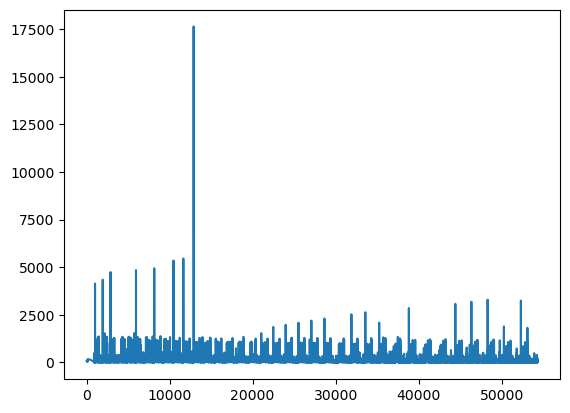

In [464]:
maindf['bid_ask_spread_bps'] = maindf['bid_ask_spread_bps'].clip(lower=0)
maindf['bid_ask_spread_bps'].plot()


In [465]:
maindf['spread_bps_diff'] = maindf.groupby('Ticker')['bid_ask_spread_bps'].diff()

In [468]:
df_encoded['spread_bps_pct_change'] = df_encoded['spread_bps_pct_change'].replace([np.inf, -np.inf], np.nan)

In [488]:
#defining X and y
y = df_encoded['bid_ask_spread_bps']
X = df_encoded[set23]

In [489]:
# encode categoricals beforehand -> df_encoded
#y = df_encoded['monthly_return'] -- NOT NEEDED EARLIER CODE ALREADY DEFINES Y

# choose/assemble your feature columns
#X = df_encoded.drop(columns=['monthly_return','Date']) -- NOT NEEDED AS EARLIER CODE ALREADY DEFINES X

# final NaN filter (y can’t have NaNs; X NaNs will be imputed in pipelines,
# but it’s cleaner to drop rows with y NaN and keep X rows aligned)
mask = y.notna()
X, y = X[mask], y[mask]

In [490]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error


def evaluate(y_true, y_pred, name="model"):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name:20s} | R²={r2:6.3f}  MAE={mae:8.5f}  RMSE={rmse:8.5f}")

In [491]:
cutoff = df_encoded.loc[mask, 'Date'].quantile(0.8)
train = df_encoded.loc[mask, 'Date'] <= cutoff
test  = df_encoded.loc[mask, 'Date'] >  cutoff

X_train, y_train = X[train], y[train]
X_test,  y_test  = X[test],  y[test]

# Baseline mean (no NaNs now)
train_mean = np.nanmean(y_train)
y_pred_mean = np.full(y_test.shape, train_mean)
evaluate(y_test, y_pred_mean, name="Baseline: train-mean")

Baseline: train-mean | R²=-0.021  MAE=50.16592  RMSE=112.37327


In [492]:
# Predict the train-set mean return for every test point (very hard baseline to beat in bonds)
y_pred_mean = np.full_like(y_test, fill_value=np.nan, dtype=float)
y_pred_mean[:] = np.nanmean(y_train)
evaluate(y_test, y_pred_mean, name="Baseline: train-mean")

Baseline: train-mean | R²=-0.021  MAE=50.16592  RMSE=112.37327


In [495]:
y_pred_train = gbm_pipe.predict(X_train)
evaluate(y_train, y_pred_train, name="GBM Train")

GBM Train            | R²= 0.869  MAE=26.12282  RMSE=56.61853


In [514]:
corr = X_tr_all.corr()
high_corr_pairs = [(c1, c2) for c1 in corr.columns for c2 in corr.columns 
                   if c1 < c2 and abs(corr.loc[c1,c2])>0.9]
print(high_corr_pairs)

[('PX_ASK', 'PX_BID'), ('PX_ASK', 'dirty_mid'), ('PX_BID', 'dirty_mid'), ('YLD_YTM_ASK', 'YLD_YTM_BID'), ('Ask Convexity', 'Bid Convexity'), ('Ask Convexity', 'Mod Dur (Ask)'), ('Ask Convexity', 'Mod Dur (Bid)'), ('Ask Convexity', 'Maturity'), ('Ask Convexity', 'duration_mid'), ('Ask Convexity', 'convexity_mid'), ('Bid Convexity', 'Mod Dur (Ask)'), ('Bid Convexity', 'Mod Dur (Bid)'), ('Bid Convexity', 'Maturity'), ('Bid Convexity', 'duration_mid'), ('Bid Convexity', 'convexity_mid'), ('Mod Dur (Ask)', 'Mod Dur (Bid)'), ('Mod Dur (Ask)', 'duration_mid'), ('Mod Dur (Ask)', 'convexity_mid'), ('Mod Dur (Ask)', 'years_to_mty'), ('Mod Dur (Bid)', 'duration_mid'), ('Mod Dur (Bid)', 'convexity_mid'), ('Mod Dur (Bid)', 'years_to_mty'), ('Cpn', 'Yield at Issue'), ('Maturity', 'Mod Dur (Ask)'), ('Maturity', 'Mod Dur (Bid)'), ('Maturity', 'duration_mid'), ('Maturity', 'convexity_mid'), ('Maturity', 'years_to_mty'), ('Ask Price', 'Bid Price'), ('CPN_FREQ', 'LastCouponDate'), ('CPN_FREQ', 'NextCoupo

In [476]:
bad_cols = [c for c in X_tr_all.columns if np.isinf(X_tr_all[c]).any()]
print(bad_cols)

[]


In [484]:
print("X_tr dtype:", getattr(X_tr, "dtype", "df"))
print("Any pd.NA in X_tr? ->", any((pd.isna(pd.Series(X_tr.ravel(), dtype="object")))))

X_tr dtype: object
Any pd.NA in X_tr? -> True


In [501]:
bad = df.select_dtypes(include=["object", "boolean"]).columns.tolist()
nullable_int = [c for c in df.columns if str(df[c].dtype).lower() in ("int64", "uint64", "int32", "uint32", "Int64", "UInt64", "boolean")]
print("Object/boolean columns:", bad)
print("Nullable integer/boolean columns:", nullable_int[:20], "… total", len(nullable_int))

Object/boolean columns: []
Nullable integer/boolean columns: ['Issue Date', 'Maturity', 'CPN_FREQ', 'LastCouponDate', 'NextCouponDate', 'row_in_bond'] … total 6


In [532]:
list1 = final_merge['BICS Level 2'].unique().to_list()
    
print(list1)

['Real Estate', 'Industrial Other', 'Forest & Paper Products Manufacturing', 'Power Generation', 'Waste & Environment Services & Equipment', 'Utilities', 'Government Development Banks', 'Government Regional', 'Containers & Packaging', 'Consumer Finance', 'Renewable Energy', 'Banks', 'Financial Services', 'Transportation & Logistics', 'Travel & Lodging', 'Commercial Finance', 'Wireline Telecommunications Services', 'Chemicals', 'Wireless Telecommunications Services', 'Diversified Banks', 'Consumer Products', 'Railroad', 'Life Insurance', 'Cable & Satellite', 'Funds & Trusts', 'Automobiles Manufacturing', 'Auto Parts Manufacturing', 'Refining & Marketing', 'Food & Beverage', 'Integrated Oils', 'Construction Materials Manufacturing', 'Property & Casualty Insurance', 'Homebuilders', 'Health Care Facilities & Services', 'Distributors - Consumer Discretionary', 'Home Improvement', 'Medical Equipment & Devices Manufacturing', 'Semiconductors', 'Electrical Equipment Manufacturing', 'Retail - C

In [534]:
maindf['S&P500 VOLATILITY INDEX'].corr(maindf['EURO STOXX 50 VOLATILITY'])


0.9344267872957249



RUNNING COMPLETE SECTOR ANALYSIS

[1/5] Analyzing feature importance...

TOP 30 FEATURES BY IMPORTANCE
   duration_spread........................................ 0.181205
   is_investment_grade.................................... 0.139212
   Amount issued.......................................... 0.064235
   rating_numeric......................................... 0.062383
   years_to_mty........................................... 0.054922
   Accrual period......................................... 0.040975
   Mod Dur (Bid).......................................... 0.040735
   Cpn.................................................... 0.039897
   period_months.......................................... 0.036884
🏭 is_utilities........................................... 0.032991
   dirty_mid.............................................. 0.031381
   Par Amount............................................. 0.030345
   CPN_FREQ............................................... 0.027994
🏭 BICS Level

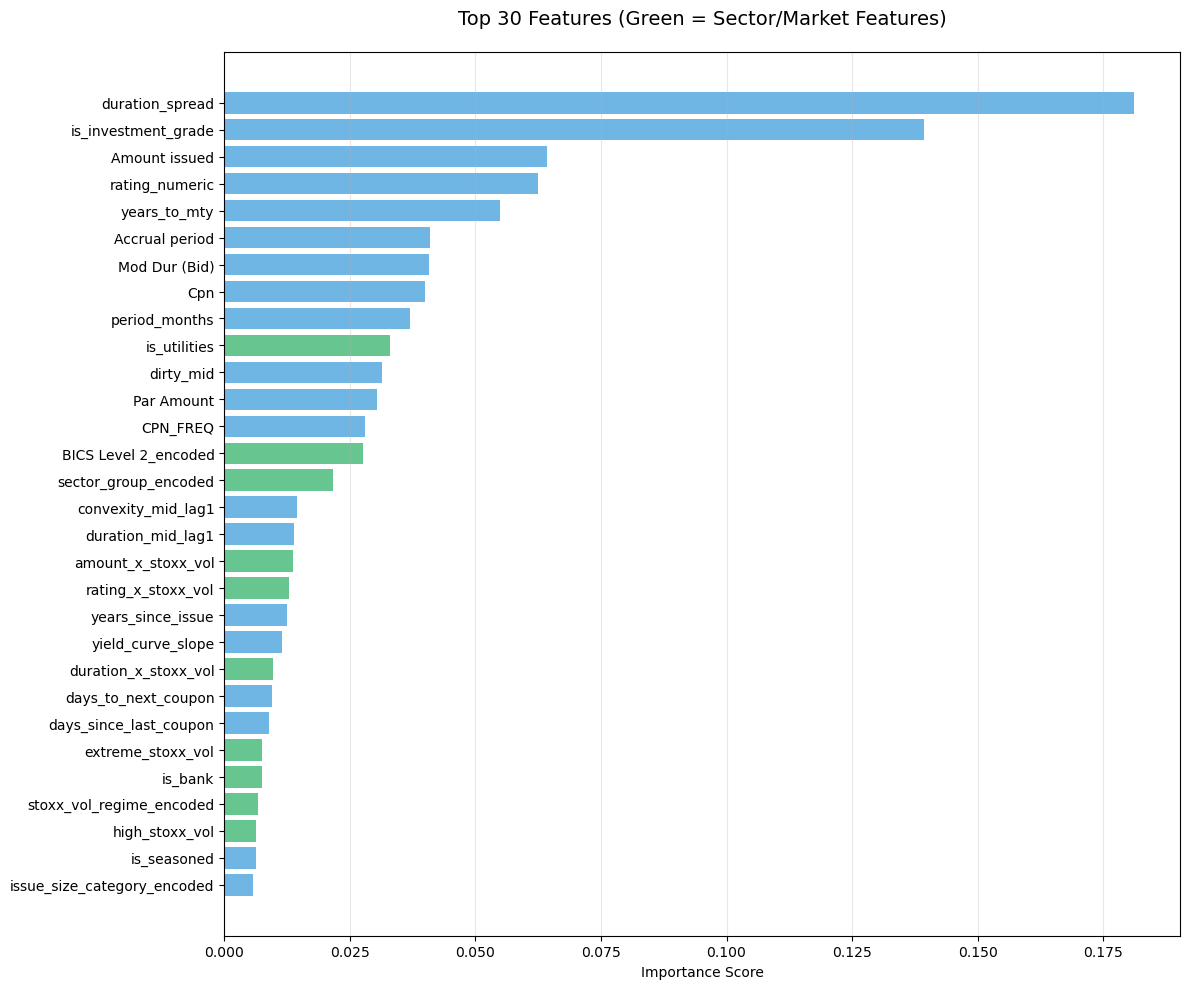


[2/5] Analyzing sectors...

SECTOR-SPECIFIC LIQUIDITY ANALYSIS

1. TOP 15 BICS LEVEL 2 SECTORS BY AVERAGE SPREAD:
----------------------------------------------------------------------
                                          Avg_Spread  Med_Spread  Std_Spread  \
BICS Level 2                                                                   
Property & Casualty Insurance                 125.46      129.72       25.23   
Cable & Satellite                             114.68      113.62       24.26   
Waste & Environment Services & Equipment      113.63      113.82       50.46   
Integrated Oils                               113.13      112.11       35.10   
Wireline Telecommunications Services          112.07      105.22       67.09   
Industrial Other                              111.44       94.64       62.93   
Refining & Marketing                           92.03       85.51       34.72   
Real Estate                                    86.65       75.72       52.10   
Auto Parts Man

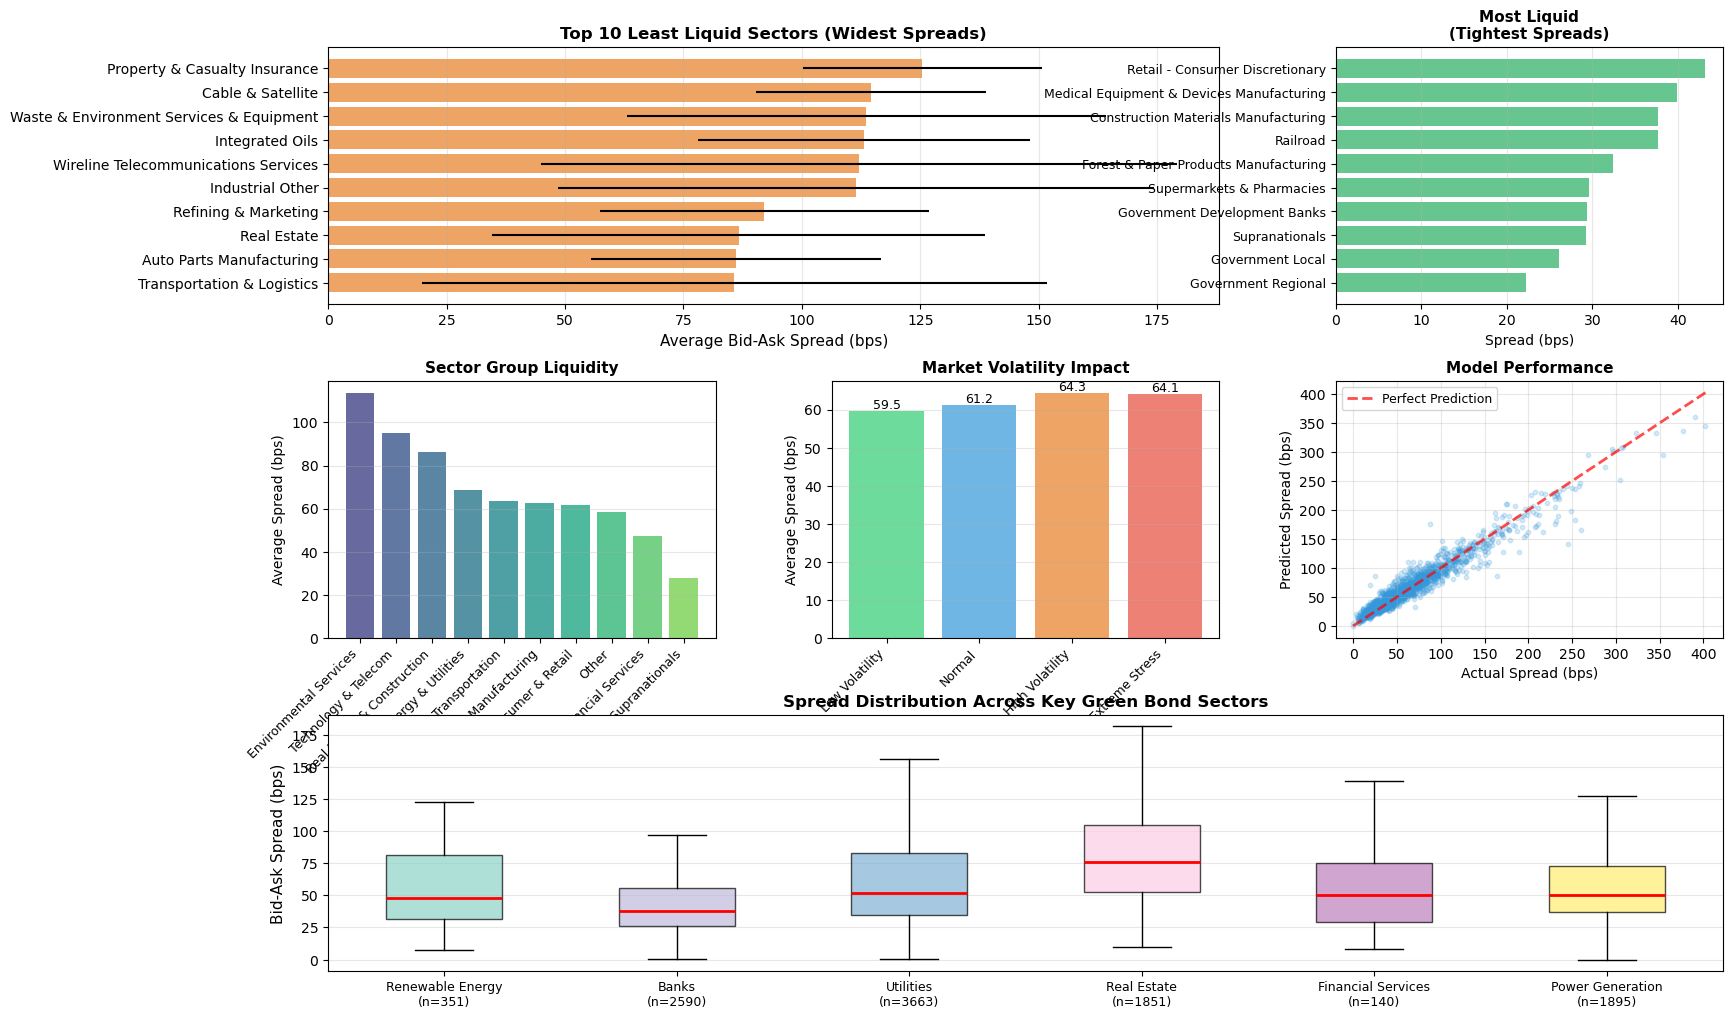


✓ Visualization saved to: green_bond_sector_analysis.png

[5/5] Generating research summary...

     GREEN BOND LIQUIDITY RESEARCH - SECTOR ANALYSIS SUMMARY

📊 MODEL PERFORMANCE:
  • Baseline model R²:      0.6728
  • Sector-enhanced R²:     0.8151
  • Improvement:            +0.1423 (21.2% gain)

🏭 KEY FINDING #1: SECTOR HETEROGENEITY
--------------------------------------------------------------------------------

  Most Liquid Green Bond Sectors (Tightest Spreads):
    1. Government Regional............................... 22.29 bps (n=393)
    2. Government Local.................................. 26.08 bps (n=35)
    3. Supranationals.................................... 29.29 bps (n=34)

  Least Liquid Green Bond Sectors (Widest Spreads):
    1. Waste & Environment Services & Equipment.......... 113.63 bps (n=153)
    2. Cable & Satellite................................. 114.68 bps (n=70)
    3. Property & Casualty Insurance..................... 125.46 bps (n=35)

  → Liquidity gap

In [540]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ============================================
# DEFINE ALL ANALYSIS FUNCTIONS
# ============================================

def analyze_sector_feature_importance(models, feature_names, top_n=30):
    """
    Analyze feature importance with focus on sector variables
    """
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': np.mean([m.feature_importances_ for m in models], axis=0)
    })
    
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Identify sector-related features
    sector_features = [
        'BICS Level 2_encoded', 'sector_group_encoded', 
        'is_renewable_energy', 'is_utilities', 'is_bank',
        'high_stoxx_vol', 'low_stoxx_vol', 'extreme_stoxx_vol',
        'stoxx_vol_regime_encoded', 'duration_x_stoxx_vol',
        'amount_x_stoxx_vol', 'rating_x_stoxx_vol'
    ]
    
    importance_df['is_sector_feature'] = importance_df['feature'].isin(sector_features)
    
    print("\n" + "="*70)
    print(f"TOP {top_n} FEATURES BY IMPORTANCE")
    print("="*70)
    
    for idx, row in importance_df.head(top_n).iterrows():
        marker = "🏭" if row['is_sector_feature'] else "  "
        print(f"{marker} {row['feature']:.<55} {row['importance']:.6f}")
    
    # Summary
    sector_in_top10 = importance_df.head(10)['is_sector_feature'].sum()
    sector_in_top25 = importance_df.head(25)['is_sector_feature'].sum()
    
    print("\n" + "="*70)
    print("SECTOR FEATURE SUMMARY")
    print("="*70)
    print(f"Sector features in top 10:  {sector_in_top10}")
    print(f"Sector features in top 25:  {sector_in_top25}")
    
    if len(importance_df[importance_df['is_sector_feature']]) > 0:
        top_sector_feature = importance_df[importance_df['is_sector_feature']].iloc[0]
        rank = importance_df[importance_df['feature'] == top_sector_feature['feature']].index[0] + 1
        print(f"\nHighest ranked sector feature:")
        print(f"  • {top_sector_feature['feature']}")
        print(f"  • Overall rank: #{rank}")
        print(f"  • Importance: {top_sector_feature['importance']:.6f}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 10))
    top_features = importance_df.head(top_n)
    colors = ['#27ae60' if x else '#3498db' for x in top_features['is_sector_feature']]
    
    ax.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance Score')
    ax.set_title(f'Top {top_n} Features (Green = Sector/Market Features)', fontsize=14, pad=20)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('sector_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return importance_df


def analyze_by_sector(df, models, features, target='bid_ask_spread_bps'):
    """
    Detailed sector-level analysis
    """
    df_analysis = df.dropna(subset=features + [target]).copy()
    X = df_analysis[features]
    y = df_analysis[target]
    
    # Get predictions
    df_analysis['predicted_spread'] = models[-1].predict(X)
    df_analysis['prediction_error'] = df_analysis[target] - df_analysis['predicted_spread']
    df_analysis['abs_error'] = np.abs(df_analysis['prediction_error'])
    
    print("\n" + "="*70)
    print("SECTOR-SPECIFIC LIQUIDITY ANALYSIS")
    print("="*70)
    
    # 1. By BICS Level 2 (Top sectors)
    print("\n1. TOP 15 BICS LEVEL 2 SECTORS BY AVERAGE SPREAD:")
    print("-" * 70)
    
    sector_analysis = df_analysis.groupby('BICS Level 2').agg({
        'bid_ask_spread_bps': ['mean', 'median', 'std'],
        'abs_error': ['mean'],
        'BICS Level 2': 'count'
    }).round(2)
    sector_analysis.columns = ['Avg_Spread', 'Med_Spread', 'Std_Spread', 'MAE', 'Count']
    sector_analysis = sector_analysis[sector_analysis['Count'] >= 10]
    sector_analysis = sector_analysis.sort_values('Avg_Spread', ascending=False)
    
    print(sector_analysis.head(15))
    
    # 2. By Sector Group
    print("\n2. SECTOR GROUP COMPARISON:")
    print("-" * 70)
    
    group_analysis = df_analysis.groupby('sector_group').agg({
        'bid_ask_spread_bps': ['mean', 'median', 'std'],
        'abs_error': ['mean'],
        'sector_group': 'count'
    }).round(2)
    group_analysis.columns = ['Avg_Spread', 'Med_Spread', 'Std_Spread', 'MAE', 'Count']
    group_analysis = group_analysis.sort_values('Avg_Spread', ascending=False)
    
    print(group_analysis)
    
    # 3. Sector × Volatility Interaction
    print("\n3. SECTOR PERFORMANCE ACROSS VOLATILITY REGIMES:")
    print("-" * 70)
    
    interaction = df_analysis.pivot_table(
        values='bid_ask_spread_bps',
        index='sector_group',
        columns='stoxx_vol_regime',
        aggfunc='mean'
    ).round(2)
    
    # Calculate stress sensitivity
    if 'High Volatility' in interaction.columns and 'Low Volatility' in interaction.columns:
        interaction['Stress_Premium'] = interaction['High Volatility'] - interaction['Low Volatility']
        interaction = interaction.sort_values('Stress_Premium', ascending=False)
    
    print(interaction)
    
    # 4. Key sector comparisons
    print("\n4. KEY SECTOR COMPARISONS:")
    print("-" * 70)
    
    key_sectors = ['Renewable Energy', 'Banks', 'Utilities', 'Power Generation', 
                   'Real Estate', 'Transportation & Logistics']
    
    for sector in key_sectors:
        if sector in df_analysis['BICS Level 2'].values:
            sector_data = df_analysis[df_analysis['BICS Level 2'] == sector]
            if len(sector_data) >= 5:
                print(f"\n{sector}:")
                print(f"  • Average spread: {sector_data['bid_ask_spread_bps'].mean():.2f} bps")
                print(f"  • Median spread:  {sector_data['bid_ask_spread_bps'].median():.2f} bps")
                print(f"  • Observations:   {len(sector_data)}")
                
                # By volatility
                low_vol = sector_data[sector_data['low_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
                high_vol = sector_data[sector_data['high_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
                if not np.isnan(low_vol) and not np.isnan(high_vol):
                    print(f"  • Low vol spread: {low_vol:.2f} bps")
                    print(f"  • High vol spread: {high_vol:.2f} bps")
                    print(f"  • Stress premium: {high_vol - low_vol:.2f} bps ({(high_vol/low_vol-1)*100:.1f}%)")
    
    return df_analysis, sector_analysis, group_analysis, interaction


def test_sector_differences(df):
    """
    Test statistical significance of sector differences
    """
    print("\n" + "="*70)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("="*70)
    
    # 1. ANOVA across sector groups
    print("\n1. SECTOR GROUP DIFFERENCES (ANOVA):")
    print("-" * 70)
    
    groups = [group['bid_ask_spread_bps'].dropna().values 
              for name, group in df.groupby('sector_group') if len(group) >= 10]
    
    if len(groups) >= 2:
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.10f}")
        print(f"Significant at 1% level: {'YES ✓✓✓' if p_value < 0.01 else 'NO'}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")
    
    # 2. Renewable Energy vs Others
    print("\n2. RENEWABLE ENERGY vs OTHER SECTORS (T-test):")
    print("-" * 70)
    
    renewable = df[df['BICS Level 2'] == 'Renewable Energy']['bid_ask_spread_bps'].dropna()
    others = df[df['BICS Level 2'] != 'Renewable Energy']['bid_ask_spread_bps'].dropna()
    
    if len(renewable) >= 10 and len(others) >= 10:
        t_stat, p_value = stats.ttest_ind(renewable, others)
        print(f"Renewable Energy mean: {renewable.mean():.2f} bps")
        print(f"Other sectors mean:    {others.mean():.2f} bps")
        print(f"Difference:            {renewable.mean() - others.mean():.2f} bps")
        print(f"T-statistic:           {t_stat:.4f}")
        print(f"P-value:               {p_value:.6f}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")
    
    # 3. Banks vs Non-Financial
    print("\n3. FINANCIAL SERVICES vs NON-FINANCIAL (T-test):")
    print("-" * 70)
    
    financial = df[df['sector_group'] == 'Financial Services']['bid_ask_spread_bps'].dropna()
    non_financial = df[df['sector_group'] != 'Financial Services']['bid_ask_spread_bps'].dropna()
    
    if len(financial) >= 10 and len(non_financial) >= 10:
        t_stat, p_value = stats.ttest_ind(financial, non_financial)
        print(f"Financial Services mean: {financial.mean():.2f} bps")
        print(f"Non-Financial mean:      {non_financial.mean():.2f} bps")
        print(f"Difference:              {financial.mean() - non_financial.mean():.2f} bps")
        print(f"T-statistic:             {t_stat:.4f}")
        print(f"P-value:                 {p_value:.6f}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")
    
    # 4. High vs Low Volatility
    print("\n4. HIGH vs LOW STOXX VOLATILITY (T-test):")
    print("-" * 70)
    
    high_vol = df[df['high_stoxx_vol'] == 1]['bid_ask_spread_bps'].dropna()
    low_vol = df[df['low_stoxx_vol'] == 1]['bid_ask_spread_bps'].dropna()
    
    if len(high_vol) >= 10 and len(low_vol) >= 10:
        t_stat, p_value = stats.ttest_ind(high_vol, low_vol)
        print(f"High volatility mean: {high_vol.mean():.2f} bps")
        print(f"Low volatility mean:  {low_vol.mean():.2f} bps")
        print(f"Stress premium:       {high_vol.mean() - low_vol.mean():.2f} bps")
        print(f"T-statistic:          {t_stat:.4f}")
        print(f"P-value:              {p_value:.6f}")
        print(f"Significant at 5% level: {'YES ✓' if p_value < 0.05 else 'NO'}")


def create_sector_visualizations(df, sector_stats, group_stats, save_path='green_bond_sector_analysis.png'):
    """
    Create publication-quality sector visualizations
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Top sectors by spread
    ax1 = fig.add_subplot(gs[0, :2])
    top_sectors = sector_stats.sort_values('Avg_Spread', ascending=True).tail(10)
    ax1.barh(range(len(top_sectors)), top_sectors['Avg_Spread'], 
             xerr=top_sectors['Std_Spread'], alpha=0.7, color='#e67e22')
    ax1.set_yticks(range(len(top_sectors)))
    ax1.set_yticklabels(top_sectors.index)
    ax1.set_xlabel('Average Bid-Ask Spread (bps)', fontsize=11)
    ax1.set_title('Top 10 Least Liquid Sectors (Widest Spreads)', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Bottom sectors by spread
    ax2 = fig.add_subplot(gs[0, 2])
    bottom_sectors = sector_stats.sort_values('Avg_Spread', ascending=True).head(10)
    ax2.barh(range(len(bottom_sectors)), bottom_sectors['Avg_Spread'], 
             alpha=0.7, color='#27ae60')
    ax2.set_yticks(range(len(bottom_sectors)))
    ax2.set_yticklabels(bottom_sectors.index, fontsize=9)
    ax2.set_xlabel('Spread (bps)', fontsize=10)
    ax2.set_title('Most Liquid\n(Tightest Spreads)', fontsize=11, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Sector group comparison
    ax3 = fig.add_subplot(gs[1, 0])
    group_sorted = group_stats.sort_values('Avg_Spread', ascending=False)
    colors_group = plt.cm.viridis(np.linspace(0.2, 0.8, len(group_sorted)))
    ax3.bar(range(len(group_sorted)), group_sorted['Avg_Spread'], 
            color=colors_group, alpha=0.8)
    ax3.set_xticks(range(len(group_sorted)))
    ax3.set_xticklabels(group_sorted.index, rotation=45, ha='right', fontsize=9)
    ax3.set_ylabel('Average Spread (bps)', fontsize=10)
    ax3.set_title('Sector Group Liquidity', fontsize=11, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Volatility regime effect
    ax4 = fig.add_subplot(gs[1, 1])
    vol_order = ['Low Volatility', 'Normal', 'High Volatility', 'Extreme Stress']
    vol_data = df.groupby('stoxx_vol_regime')['bid_ask_spread_bps'].mean().reindex(vol_order)
    colors_vol = ['#2ecc71', '#3498db', '#e67e22', '#e74c3c']
    bars = ax4.bar(range(len(vol_data)), vol_data.values, color=colors_vol, alpha=0.7)
    ax4.set_xticks(range(len(vol_data)))
    ax4.set_xticklabels(vol_data.index, rotation=45, ha='right', fontsize=9)
    ax4.set_ylabel('Average Spread (bps)', fontsize=10)
    ax4.set_title('Market Volatility Impact', fontsize=11, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Actual vs Predicted
    ax5 = fig.add_subplot(gs[1, 2])
    sample = df.sample(min(2000, len(df)))
    ax5.scatter(sample['bid_ask_spread_bps'], sample['predicted_spread'], 
                alpha=0.2, s=10, c='#3498db')
    lims = [min(sample['bid_ask_spread_bps'].min(), sample['predicted_spread'].min()),
            max(sample['bid_ask_spread_bps'].max(), sample['predicted_spread'].max())]
    ax5.plot(lims, lims, 'r--', lw=2, label='Perfect Prediction', alpha=0.7)
    ax5.set_xlabel('Actual Spread (bps)', fontsize=10)
    ax5.set_ylabel('Predicted Spread (bps)', fontsize=10)
    ax5.set_title('Model Performance', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(alpha=0.3)
    
    # 6. Spread distribution by key sectors
    ax6 = fig.add_subplot(gs[2, :])
    key_sectors = ['Renewable Energy', 'Banks', 'Utilities', 'Real Estate', 
                   'Financial Services', 'Power Generation']
    sector_data = []
    sector_labels = []
    for sector in key_sectors:
        if sector in df['BICS Level 2'].values:
            data = df[df['BICS Level 2'] == sector]['bid_ask_spread_bps'].dropna()
            if len(data) >= 10:
                sector_data.append(data)
                sector_labels.append(f"{sector}\n(n={len(data)})")
        elif sector in df['sector_group'].values:
            data = df[df['sector_group'] == sector]['bid_ask_spread_bps'].dropna()
            if len(data) >= 10:
                sector_data.append(data)
                sector_labels.append(f"{sector}\n(n={len(data)})")
    
    if sector_data:
        bp = ax6.boxplot(sector_data, labels=sector_labels, patch_artist=True,
                         showfliers=False, medianprops=dict(color='red', linewidth=2))
        colors_box = plt.cm.Set3(np.linspace(0, 1, len(sector_data)))
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax6.set_ylabel('Bid-Ask Spread (bps)', fontsize=11)
        ax6.set_title('Spread Distribution Across Key Green Bond Sectors', fontsize=12, fontweight='bold')
        ax6.grid(axis='y', alpha=0.3)
        plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=9)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Visualization saved to: {save_path}")


def generate_sector_research_summary(original_r2, enhanced_r2, importance_df, 
                                    sector_stats, group_stats, df_analysis):
    """
    Generate comprehensive research summary
    """
    print("\n" + "="*80)
    print("     GREEN BOND LIQUIDITY RESEARCH - SECTOR ANALYSIS SUMMARY")
    print("="*80)
    
    print("\n📊 MODEL PERFORMANCE:")
    print(f"  • Baseline model R²:      {original_r2:.4f}")
    print(f"  • Sector-enhanced R²:     {enhanced_r2:.4f}")
    print(f"  • Improvement:            +{(enhanced_r2 - original_r2):.4f} " +
          f"({(enhanced_r2/original_r2 - 1)*100:.1f}% gain)")
    
    print("\n🏭 KEY FINDING #1: SECTOR HETEROGENEITY")
    print("-" * 80)
    
    most_liquid = sector_stats.sort_values('Avg_Spread').head(3)
    least_liquid = sector_stats.sort_values('Avg_Spread').tail(3)
    
    print("\n  Most Liquid Green Bond Sectors (Tightest Spreads):")
    for idx, (sector, row) in enumerate(most_liquid.iterrows(), 1):
        print(f"    {idx}. {sector:.<50} {row['Avg_Spread']:.2f} bps (n={int(row['Count'])})")
    
    print("\n  Least Liquid Green Bond Sectors (Widest Spreads):")
    for idx, (sector, row) in enumerate(least_liquid.iterrows(), 1):
        print(f"    {idx}. {sector:.<50} {row['Avg_Spread']:.2f} bps (n={int(row['Count'])})")
    
    spread_range = least_liquid.iloc[0]['Avg_Spread'] - most_liquid.iloc[0]['Avg_Spread']
    print(f"\n  → Liquidity gap: {spread_range:.2f} bps " +
          f"({spread_range/most_liquid.iloc[0]['Avg_Spread']*100:.0f}% difference)")
    
    print("\n⚡ KEY FINDING #2: MARKET STRESS AMPLIFICATION")
    print("-" * 80)
    
    low_vol = df_analysis[df_analysis['low_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
    high_vol = df_analysis[df_analysis['high_stoxx_vol'] == 1]['bid_ask_spread_bps'].mean()
    stress_premium = high_vol - low_vol
    
    print(f"  • Calm markets (Low STOXX vol):   {low_vol:.2f} bps")
    print(f"  • Stressed markets (High vol):    {high_vol:.2f} bps")
    print(f"  • Market stress premium:          +{stress_premium:.2f} bps ({stress_premium/low_vol*100:.1f}%)")
    
    print("\n" + "="*80)

# ============================================
# NOW RUN THE ANALYSIS
# ============================================

print("\n\n" + "="*80)
print("RUNNING COMPLETE SECTOR ANALYSIS")
print("="*80)

# 1. Feature importance
print("\n[1/5] Analyzing feature importance...")
importance_df = analyze_sector_feature_importance(enhanced_models, all_features, top_n=30)

# 2. Sector analysis
print("\n[2/5] Analyzing sectors...")
df_with_predictions, sector_stats, group_stats, interaction_matrix = analyze_by_sector(
    maindf, enhanced_models, all_features
)

# 3. Statistical tests
print("\n[3/5] Running statistical tests...")
test_sector_differences(df_with_predictions)

# 4. Visualizations
print("\n[4/5] Creating visualizations...")
create_sector_visualizations(df_with_predictions, sector_stats, group_stats)

# 5. Summary
print("\n[5/5] Generating research summary...")
generate_sector_research_summary(
    original_r2=0.6728,
    enhanced_r2=0.8151,
    importance_df=importance_df,
    sector_stats=sector_stats,
    group_stats=group_stats,
    df_analysis=df_with_predictions
)

print("\n" + "="*80)
print("✅ COMPLETE ANALYSIS FINISHED!")
print("="*80)
print("\nYou now have:")
print("  • Feature importance rankings")
print("  • Sector liquidity comparisons")
print("  • Statistical significance tests")
print("  • Publication-quality visualizations")
print("  • Research summary for your paper")
print("="*80)